In [61]:
import numpy as np
import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import sys
# Automatic Gain Control=Checked,IR PA (mA)=10,Red PA (mA)=10,IR LED Range (mA)=51,Red LED Range (mA)=51,ALC + FDM=Checked,
# Sample Rate (Hz)=100,Pulse Width (usec)=400,ADC Range (nA)=32768,FIFO Rolls on Full=Checked,FIFO Almost Full=17,Sample 
# Averaging=1,IA Gain=5,ECG Gain=8,Sample Rate=200,Adaptive Filter=Checked,Notch Freq=60,Cutoff Freq=50,

In [78]:
### Peak Finding Parameters ###
MIN_WIDTH = 20
MAX_WIDTH = 200
PROMINENCE = 800
HEIGHT = None
THRESHOLD = None

### SpO2 Parameters ###
INTERCEPT_SPO2 = 130 # SpO2 = INTERCEPT_SPO2-SLOPE_SPO2*Ratio
SLOPE_SPO2 = 36

In [83]:
def convert_to_sec(t):
    """This function converts the string in format yyyy-mm-dd hh:mm:ss:SSS to a float
    with the format ss:SSS. Only converts from minutes down to seconds. Not for >= 1 hr
    long data.

    Args:
        t (str): datetime string with format yyyy-mm-dd hh:mm:ss:SSS

    Returns:
        total (float): seconds calculated from mm:ss.SSS
    """
    t = t[14:]
    min = float(t[:t.find(":")])
    sec = float(t[t.find(":")+1:])
    total = (min*60)+sec
    return total

def peak_valley_finder_and_plot(data, time):
    """finds the peaks of a dataset and plots the data

    Args:
        data (list/list-like): the y-axis values of the dataset
        time (list/list-like): the x-axis time values of the dataset (should be same shape as data) 

    Returns:
        list: list containing the indexes of all of the peaks in the dataset (no minimum peaks, just maxes)
    """
    peaks = find_peaks(data, height=HEIGHT, threshold=THRESHOLD, prominence=PROMINENCE, width=(MIN_WIDTH, MAX_WIDTH))[0]
    valleys = find_peaks(-data, height=HEIGHT, threshold=THRESHOLD, prominence=PROMINENCE, width=(MIN_WIDTH, MAX_WIDTH))[0]
    
    # fixes edge case where max of a peak/valley is found twice in same peak.
    usedValues_peaks = set()
    newList = []
    for v in peaks:
        if v not in usedValues_peaks:
            newList.append(v)
            for lv in range(v - MIN_WIDTH, v + MIN_WIDTH + 1):
                usedValues_peaks.add(lv)
    peaks = list(newList)
    
    usedValues_valleys = set()
    newList2 = []
    for v in valleys:
        if v not in usedValues_valleys:
            newList2.append(v)
            for lv in range(v - MIN_WIDTH, v + MIN_WIDTH + 1):
                usedValues_valleys.add(lv)
    valleys = list(newList2)
    
    #plotting
    plt.figure(figsize=(12,4))
    plt.plot(time, data, label = "Signal")
    plt.plot(time[peaks], data[peaks], "x", label = "peaks")
    plt.plot(time[valleys], data[valleys], "x", label="valleys")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal Count")
    plt.title("Signal Count vs Time")
    plt.legend()
    plt.show()
    return peaks, valleys

In [56]:
# CSV # 1
#df = pd.read_csv("C:\data\honors project ppg data\ECPPG_2023-10-21_21-29-57.csv") #Karston
df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21_21-29-57.csv") #Pablo

# CSV # 2
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21_23-45-37.csv") # Pablo

# CSV # 3
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21.csv") # Pablo
df.head

<bound method NDFrame.head of                          Time   Sample Count   IR Count   Red Count   Raw ECG  \
0     2023-10-21 21:30:51.750          11728     233049      209594     -7427   
1     2023-10-21 21:30:51.782          11729     233094      209607     -7419   
2     2023-10-21 21:30:51.783          11730     233090      209595     -7526   
3     2023-10-21 21:30:51.783          11731     233113      209598     -7379   
4     2023-10-21 21:30:51.783          11732     233142      209611     -7651   
...                       ...            ...        ...         ...       ...   
5020  2023-10-21 21:31:16.861          16748     237060      206019      3901   
5021  2023-10-21 21:31:16.861          16749     237052      206017      3765   
5022  2023-10-21 21:31:16.861          16750     237040      205990      3965   
5023  2023-10-21 21:31:16.861          16751     237056      205995      3713   
5024  2023-10-21 21:31:16.861          16752     237052      205999      3722  

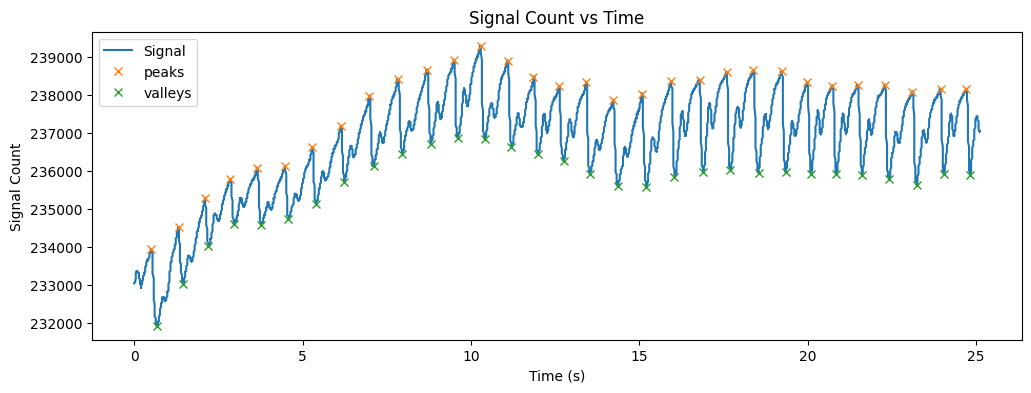

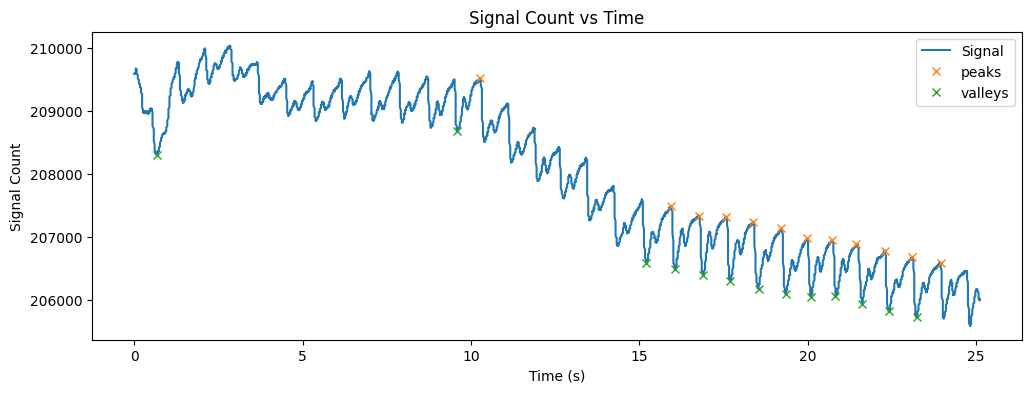

In [81]:
time = np.array([convert_to_sec(x) for x in df["Time"]]) - convert_to_sec(df["Time"][0])
IR_Count = df[" IR Count"]
Red_Count = df[" Red Count"]
peaks_ir, valleys_ir = peak_valley_finder_and_plot(IR_Count, time)
peaks_red, valleys_red = peak_valley_finder_and_plot(Red_Count, time)
# print(peaks)
# widths = peak_widths(IR_Count, peaks=peaks)
# print(widths)

In [80]:
### USING THE IR COUNT ###
peak_times_ir = list(set(np.round(time[peaks_ir], 3)))
peak_vals_ir = IR_Count[peaks_ir]

valley_times_ir = list(set(np.round(time[valleys_ir], 3)))
valley_vals_ir = IR_Count[valleys_ir]

diffs_peaks_ir = np.diff(peak_times_ir)
diffs_valleys_ir = np.diff(valley_times_ir)

#average over the whole timeframe
avg_bpm_peaks_ir = 60*(1/np.mean(diffs_peaks_ir))
avg_bpm_valleys_ir = 60*(1/np.mean(diffs_valleys_ir))

#moving average every 5 heartbeats
try:
    bpms_peaks_ir = [60*(1/np.mean(diffs_peaks_ir[i:i+5])) for i in range(len(diffs_peaks_ir) - 5)]
    bpms_valleys_ir = [60*(1/np.mean(diffs_valleys_ir[i:i+5])) for i in range(len(diffs_valleys_ir) - 5)]
except IndexError:
    sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")
    
print("-------Based on IR Count-------")
print(f'Average BPM over time interval using peaks: {avg_bpm_peaks_ir:.2f}')
print(f'Average BPM over time interval using valleys: {avg_bpm_valleys_ir:.2f}')
print("BPM Moving Average with window length of 5 Heartbeats:")
print("Based on peaks: ",np.round(bpms_peaks_ir, 2))
print("Based on valleys: ", np.round(bpms_valleys_ir, 2))

-------Based on IR Count-------
Average BPM over time interval using peaks: 74.33
Average BPM over time interval using valleys: 74.53
BPM Moving Average with window length of 5 Heartbeats:
Based on peaks:  [75.06 75.66 74.44 72.69 71.68 71.12 71.58 72.2  72.71 74.39 76.79 76.26
 76.18 75.64 73.3  71.6  71.62 72.18 72.17 74.39 76.2  77.38 76.73 77.4
 75.62]
Based on valleys:  [76.82 76.14 74.37 72.15 71.63 70.6  71.11 71.67 73.31 74.42 76.18 76.24
 76.18 75.02 73.86 72.69 72.13 71.67 72.17 73.82 75.66 76.77 77.4  77.38
 76.22]


In [82]:
### USING THE RED COUNT ###
peak_times_red = list(set(np.round(time[peaks_red], 3)))
peak_vals_red = Red_Count[peaks_red]

valley_times_red = list(set(np.round(time[valleys_red], 3)))
valley_vals_red = Red_Count[valleys_red]

diffs_peaks_red = np.diff(peak_times_red)
diffs_valleys_red = np.diff(valley_times_red)

#average over the whole timeframe
avg_bpm_peaks_red = 60*(1/np.mean(diffs_peaks_red))
avg_bpm_valleys_red = 60*(1/np.mean(diffs_valleys_red))

#moving average every 5 heartbeats
try:
    bpms_peaks_red = [60*(1/np.mean(diffs_peaks_red[i:i+5])) for i in range(len(diffs_peaks_red) - 5)]
    bpms_valleys_red = [60*(1/np.mean(diffs_valleys_red[i:i+5])) for i in range(len(diffs_valleys_red) - 5)]
except IndexError:
    sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")
    
print("-------Based on Red Count-------")
print(f'Average BPM over time interval using peaks: {avg_bpm_peaks_red:.2f}')
print(f'Average BPM over time interval using valleys: {avg_bpm_valleys_red:.2f}')
print("BPM Moving Average with window length of 5 Heartbeats:")
print("Based on peaks: ",np.round(bpms_peaks_red, 2))
print("Based on valleys: ", np.round(bpms_valleys_red, 2))

-------Based on Red Count-------
Average BPM over time interval using peaks: 48.22
Average BPM over time interval using valleys: 31.91
BPM Moving Average with window length of 5 Heartbeats:
Based on peaks:  [33.57 74.39 75.53 77.44 76.73 76.79]
Based on valleys:  [17.62 33.47 72.17 93.23 63.13 76.77 77.4 ]
